# 1. Introduction

This model is based on encoder-decoder structure. And is uesd for French-English translation tasks

# 2.Data preprocessing

## 2.1 Import related packages

In [26]:

from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as DataSet

import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()


## 2.2Prepare parallel corpus

In [27]:
# Define two special symbols, corresponding to the beginning and end of the sentence
SOS_token = 0
EOS_token = 1

lines = open('fra.txt', encoding = 'utf-8')
french = lines.read().strip().split('\n')
lines = open('eng.txt', encoding = 'utf-8')
english = lines.read().strip().split('\n')
print(len(french))
print(len(english))

135842
135842


In [28]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [29]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeEngString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    for i in range(MAX_LENGTH - len(indexes)):
        indexes.append(EOS_token)
    return(indexes)

def indexFromPair(pair):
    input_variable = indexFromSentence(input_lang, pair[0])
    target_variable = indexFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

def SentenceFromList(lang, lst):
    result = [lang.index2word[i] for i in lst if i != EOS_token]
    if lang.name == 'French':
        result = ' '.join(result)
    else:
        result = ' '.join(result)
    return(result)

In [30]:
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data).sum() 
    return rights, len(labels)

## 2.3 Split Data Set

In [31]:
MAX_LENGTH = 8

pairs = [[normalizeEngString(fra), normalizeEngString(eng)] for fra, eng in zip(french, english)]

input_lang = Lang('French')
output_lang = Lang('English')
pairs = [pair for pair in pairs if filterPair(pair)]

有效句子对： 57400


In [32]:
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("Vacub:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)

总单词数:
French 12914
English 7745


In [33]:
# Form the training set, first, disrupt the order of all sentences
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]

# Sentence id formed by encoding the language into words
pairs = [indexFromPair(pair) for pair in pairs]
valid_size = len(pairs) // 10

if valid_size > 10000:
    valid_size = 10000
pp = pairs
pairs = pairs[ : - valid_size]
valid_pairs = pp[-valid_size : -valid_size // 2]
test_pairs = pp[- valid_size // 2 :]

batch_size = 512 

print('Training   set samples：', len(pairs))
print('Validation set samples：', len(valid_pairs))
print('Test       set samples：', len(test_pairs))

# Form a list of training pairs for feeding to train_dataset
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]

训练记录： 51660
校验记录： 2870
测试记录： 2870


In [34]:

train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y))
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)

# 3. Encoder-decoder model 

## 3.1 Implementation of the encoder

In [35]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True, 
                          num_layers = self.n_layers, bidirectional = True)

    def forward(self, input, hidden):

        #input： batch_size, length_seq
        embedded = self.embedding(input)
        #embedded：batch_size, length_seq, hidden_size
        output = embedded
        output, hidden = self.gru(output, hidden)
        # output：batch_size, length_seq, hidden_size
        # hidden：num_layers * directions, batch_size, hidden_size
        return output, hidden

    def initHidden(self, batch_size):
        #num_layers * num_directions, batch, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## 3.2 Implementation of the decoder

In [36]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True,
                        num_layers = self.n_layers, bidirectional = True)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        # input：batch_size, length_seq
        output = self.embedding(input)
        # embedded：batch_size, length_seq, hidden_size
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.dropout(output)
        # output：batch_size, length_seq, hidden_size * directions
        # hidden：n_layers * directions, batch_size, hidden_size
        output = self.softmax(self.out(output[:, -1, :]))
        # output：batch_size * output_size

        return output, hidden

    def initHidden(self):
        # ：num_layers * directions, batch_size, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## 3.3 Start training

### 3.3.1 Instantiate encoder, decoder, define optimizer, loss function and other components

In [37]:
hidden_size = 128
max_length = MAX_LENGTH
n_layers = 1

encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers = n_layers)
decoder = DecoderRNN(hidden_size, output_lang.n_words, n_layers = n_layers)

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

learning_rate = 0.0001

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()
teacher_forcing_ratio = 0.5

### 3.3.2 Define the training function

In [38]:
plot_losses = []

print_loss_total = 0

print_loss_avg = 0

def train_simple_model():
    global plot_losses
    global print_loss_total
    global print_loss_avg
    print_loss_total = 0


    for data in train_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable：batch_size, length_seq

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        loss = 0

        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs：batch_size, length_seq, hidden_size*direction
        # encoder_hidden：direction*n_layer, batch_size, hidden_size

        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        decoder_hidden = encoder_hidden
        # decoder_hidden：direction*n_layer, batch_size, hidden_size

        # Use the translation result in target as the supervision information in the ratio of teacher_forcing_ratio
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        base = torch.zeros(target_variable.size()[0])
        if use_teacher_forcing:
            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # decoder_ouput：batch_size, output_size
                loss += criterion(decoder_output, target_variable[:, di])
                decoder_input = target_variable[:, di].unsqueeze(1)  # Teacher forcing
                # decoder_input：batch_size, length_seq

        else:
            # No Teacher forcing
            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                #decoder_ouput：batch_size, output_size(vocab_size)
                topv, topi = decoder_output.data.topk(1, dim = 1)
                #topi ：batch_size, k
                ni = topi[:, 0]

                decoder_input = Variable(ni.unsqueeze(1))
                # decoder_input：batch_size, length_seq
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input

                loss += criterion(decoder_output, target_variable[:, di])

        loss.backward()
        loss = loss.cpu() if use_cuda else loss

        encoder_optimizer.step()
        decoder_optimizer.step()

        print_loss_total += loss.data.numpy()

    print_loss_avg = print_loss_total / len(train_loader)

### 3.3.3 Model verification function

In [39]:
valid_loss = 0
rights = []

def evaluation_simple_model():
    global valid_loss
    global rights
    valid_loss = 0
    rights = []


    for data in valid_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable：batch_size, length_seq

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs：batch_size, length_seq, hidden_size*direction
        # encoder_hidden：direction*n_layer, batch_size, hidden_size

        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        decoder_hidden = encoder_hidden
        # decoder_hidden：direction*n_layer, batch_size, hidden_size

        for di in range(MAX_LENGTH):

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #decoder_ouput：batch_size, output_size(vocab_size)

            topv, topi = decoder_output.data.topk(1, dim = 1)
            #topi ：batch_size, k
            ni = topi[:, 0]
            decoder_input = Variable(ni.unsqueeze(1))
            # decoder_input：batch_size, length_seq
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            # Calculate the accuracy of the prediction, record it in right, 
             #right is a two-tuple, and store the number and total number of guesses respectively
            right = rightness(decoder_output, target_variable[:, di])
            rights.append(right)

            loss += criterion(decoder_output, target_variable[:, di])
        loss = loss.cpu() if use_cuda else loss

        valid_loss += loss.data.numpy()

### 3.3.4 Start training

In [41]:

plot_losses = []

num_epoch = 100
for epoch in range(num_epoch):
    train_simple_model()

    evaluation_simple_model()

    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('Process：%d%% Train-loss：%.4f，Valid-loss：%.4f，word accuracy：%.2f%%' % (epoch * 1.0 / num_epoch * 100, 
                                                    print_loss_avg,
                                                    valid_loss / len(valid_loader),
                                                    100.0 * right_ratio))

    plot_losses.append([print_loss_avg, valid_loss / len(valid_loader), right_ratio])

Process：0% train-loss：21.4703，valid-loss：22.8573，word accuracy：53.33%
Process：2% train-loss：21.2368，valid-loss：22.4954，word accuracy：53.82%
Process：4% train-loss：21.0322，valid-loss：22.3210，word accuracy：54.18%
Process：6% train-loss：20.7596，valid-loss：22.2321，word accuracy：54.27%
Process：8% train-loss：20.5247，valid-loss：21.9457，word accuracy：54.72%
Process：10% train-loss：20.2602，valid-loss：21.7965，word accuracy：55.01%
Process：12% train-loss：20.0684，valid-loss：21.6370，word accuracy：55.51%
Process：14% train-loss：19.9300，valid-loss：21.4802，word accuracy：55.72%
Process：16% train-loss：19.6365，valid-loss：21.2013，word accuracy：56.13%
Process：18% train-loss：19.1906，valid-loss：21.2337，word accuracy：56.03%
Process：20% train-loss：19.1294，valid-loss：20.9445，word accuracy：56.45%
Process：22% train-loss：19.0255，valid-loss：20.7923，word accuracy：56.75%
Process：24% train-loss：18.8785，valid-loss：20.5606，word accuracy：57.23%
Process：26% train-loss：18.5813，valid-loss：20.5634，word accuracy：57.12%
Process：28%

### 3.3.5 Drawing the training error curve of the model

In [44]:
np.savetxt('plot_losses_normal.txt',plot_losses)

<IPython.core.display.Javascript object>


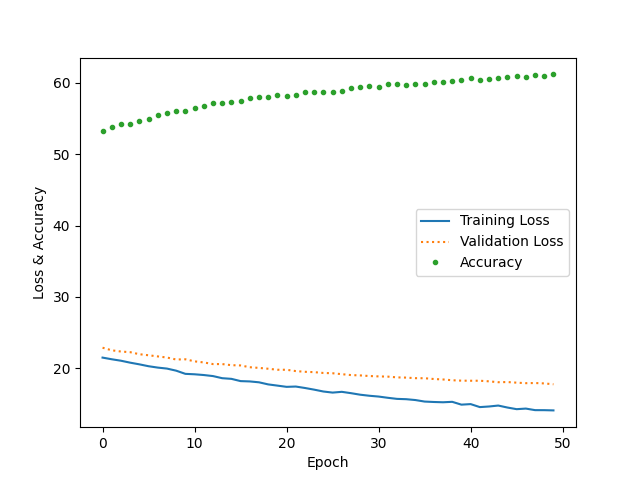

In [45]:
%matplotlib notebook
a = [i[0] for i in plot_losses]
b = [i[1] for i in plot_losses]
c = [i[2] * 100 for i in plot_losses]
plt.plot(a, '-', label = 'Training Loss')
plt.plot(b, ':', label = 'Validation Loss')
plt.plot(c, '.', label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend()

### 3.3.6 Save Model

In [46]:
torch.save(encoder,'encoder_cpu.mdl')
torch.save(decoder,'decoder_cpu.mdl')

### 3.3.7 Load Model


In [47]:

encoder = torch.load("encoder_cpu.mdl")
decoder = torch.load("decoder_cpu.mdl")

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

## 3.4 Test model

In [53]:
max_length = MAX_LENGTH

# First, randomly select 20 sentences in the test set as the test
indices = np.random.choice(range(len(test_X)), 20)

for ind in indices:
    data = [test_X[ind]]
    target = [test_Y[ind]]
    print(SentenceFromList(input_lang, data[0]))
    input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
    # input_variable：batch_size, length_seq
    target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
    # target_variable：batch_size, length_seq

    encoder_hidden = encoder.initHidden(input_variable.size()[0])

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    # encoder_outputs：batch_size, length_seq, hidden_size*direction
    # encoder_hidden：direction*n_layer, batch_size, hidden_size

    decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
    # decoder_input：batch_size, length_seq
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden
    # decoder_hidden：direction*n_layer, batch_size, hidden_size

    output_sentence = []
    decoder_attentions = torch.zeros(max_length, max_length)
    rights = []
    for di in range(MAX_LENGTH):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        #decoder_ouput：batch_size, output_size(vocab_size)

        topv, topi = decoder_output.data.topk(1, dim = 1)
        #topi ：batch_size, k
        ni = topi[:, 0]
        decoder_input = Variable(ni.unsqueeze(1))
        ni = ni.cpu().numpy()[0]

        output_sentence.append(ni)
        # decoder_input：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        right = rightness(decoder_output, target_variable[:, di])
        rights.append(right)

    sentence = SentenceFromList(output_lang, output_sentence)
    standard = SentenceFromList(output_lang, target[0])

    print('model     translation：', sentence)
    print('reference translation：', standard)
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('word accuracy：', 100.0 * right_ratio)
    print('\n')

elle connait tout du francais .
model     translation： she s in with .
reference translation： she knows french inside out .
word accuracy： tensor(37.5000, device='cuda:0')


s il vous plait arretez .
model     translation： please please .
reference translation： please stop .
word accuracy： tensor(87.5000, device='cuda:0')


mon travail est presque fini .
model     translation： my is is in his .
reference translation： my work is almost finished .
word accuracy： tensor(62.5000, device='cuda:0')


je sais que vous voulez aider .
model     translation： i know what you want . .
reference translation： i know you want to help .
word accuracy： tensor(50., device='cuda:0')


je ne travaillerai jamais pour toi .
model     translation： i m never to you you .
reference translation： i ll never work for you .
word accuracy： tensor(62.5000, device='cuda:0')


il est mignon dans son genre .
model     translation： he is in his his his .
reference translation： he s kind of cute .
word accuracy： tensor(2

In [52]:
from nltk.translate.bleu_score import sentence_bleu
reference = ['how', 'are' ,'you','going','?']
candidate = ['how', 'are', 'you','get','?']
score = sentence_bleu([reference],candidate,weights=(0.5, 0.5))
score

0.6324555320336759